In [1]:
import copy
import sys
sys.path.insert(0, "..")
import numpy as np
import matplotlib.pyplot as plt
from classes.atom_classes.atom_collection import Atom_Collection
from classes.atom_classes.atom import Atom
from classes.atom_classes.atom_collection_plotter import Atom_Collection_Plotter, Animator
from classes.descriptors import PairDistances, CoulombMatrixSpectrum
from classes.regression.regressers import RBF_kernel_regressor, Gaussian_kernel_regressor
from classes.calculators.lennardjones import LennardJones

In [2]:
class Atom_plotter(Animator):
    def __init__(self, default_cols=("C0", "C1"), markersize=50, scale_with_mass=False, alpha=1) -> None:
        super().__init__(default_cols, markersize, scale_with_mass, alpha)

Text(0.5, 0, '$x$')

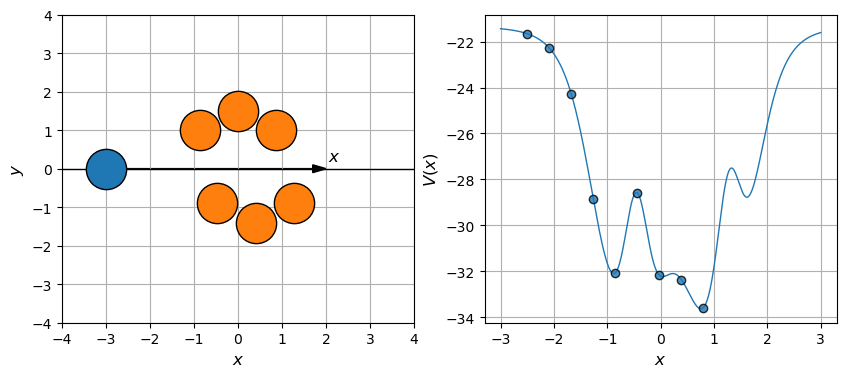

In [4]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
for ax in axs:
    ax.grid()

axs[0].set_xlim([-4.0, 4.0])
axs[0].set_ylim([-4.0, 4.0])
axs[0].set_xlabel(r"$x$", fontsize=12)
axs[0].set_ylabel(r"$y$", fontsize=12)

v_angle = lambda v: np.array([np.cos(v), np.sin(v)])

p1 = np.array([0.0, 1.0+np.sin(np.pi/6.0)]) #+ np.array([0.0, -0.1])
p2 = p1 + v_angle(7.0*np.pi/6.0)
p3 = p1 + v_angle(-np.pi/6.0)
p4 = np.array([0.0, -0.95])#p1 - np.array([0.0, 2.0])

positions = [p1, p2, p3]
atomlist = [Atom(position=position, frozen=True) for position in positions]+[Atom(position=-position+np.array([0.4,0.10]), frozen=True) for position in positions] + [Atom(position=np.array([-3.0, 0.0]))]
atom_col = Atom_Collection(atomlist=atomlist)
atom_col.calculator = LennardJones()
atom_col.reset_plot_axes()

axs[0].hlines(0.0, -5.0, 5.0, colors="k", lw=1)
axs[0].arrow(-3.0, 0.0, 5,0, lw=1.1, length_includes_head=True, head_width=0.2, fc="k")
axs[0].annotate(r"$x$", (2.05,0.2), fontsize=12)
atom_plotter = Atom_plotter(markersize=29)
atom_plotter(atom_col=atom_col, ax=axs[0])


coul_desc_maker = CoulombMatrixSpectrum()
pair_desc_maker = PairDistances()

xs = np.linspace(-3.0, 3.0, 500)
pot_es = np.zeros(len(xs))
coul_descs = np.zeros(shape=(len(xs), 7))
pair_descs = np.zeros(shape=(len(xs), 14))

for i, x in enumerate(xs):
    atom_col.set_atom_pos(index=[-1], pos=np.array([x, 0.0]))
    pot_es[i] = atom_col.get_potential_energy()
    pair_descs[i] = pair_desc_maker.get_descriptor(atom_col=atom_col)
    coul_descs[i] = coul_desc_maker.get_descriptor(atom_col=atom_col)
atom_col.set_atom_pos(index=[-1], pos=np.array([-3.0, 0.0]))



sample_points = np.linspace(-2.5, 0.8, 9)
pot_es_sampled = np.zeros(len(sample_points))
pair_desc_sampled = np.zeros(shape=(len(sample_points), 14))
coul_desc_sampled = np.zeros(shape=(len(sample_points), 7))


for i, sample_point in enumerate(sample_points):
    atom_col.set_atom_pos(index=[-1], pos=np.array([sample_point, 0.0]))
    pot_es_sampled[i] = atom_col.get_potential_energy()
    pair_desc_sampled[i] = pair_desc_maker.get_descriptor(atom_col=atom_col)
    coul_desc_sampled[i] = coul_desc_maker.get_descriptor(atom_col=atom_col)

atom_col.set_atom_pos(index=[-1], pos=np.array([-3.0, 0.0]))

axs[1].plot(xs, pot_es, lw=1)
axs[1].plot(sample_points, pot_es_sampled, "o", c="C0", markeredgecolor="k", alpha=0.8)
axs[1].set_ylabel(r"$V(x)$", fontsize=12)
axs[1].set_xlabel(r"$x$", fontsize=12)

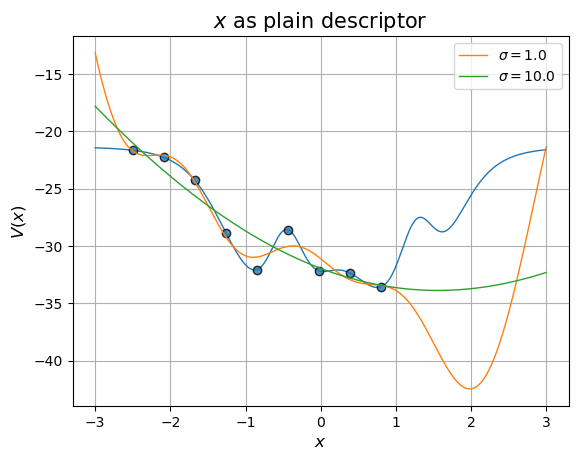

In [5]:
fig, ax = plt.subplots()
sigmas = [1.0, 10.0]
xs = np.linspace(-3.0, 3.0, 500)

ax.set_title(r"$x$ as plain descriptor", fontsize=15)

ax.plot(xs, pot_es, lw=1)
ax.plot(sample_points, pot_es_sampled, "o", c="C0", markeredgecolor="k", alpha=0.8)
ax.set_ylabel(r"$V(x)$", fontsize=12)
ax.set_xlabel(r"$x$", fontsize=12)
ax.grid()
for sigma in sigmas:
    regressor = Gaussian_kernel_regressor(x_data=sample_points.reshape(-1,1), y_data=pot_es_sampled.reshape(-1,1), lamb=1e-4, sigma=sigma)
    y_pred = regressor.sample(xs.reshape(-1,1))
    ax.plot(xs, y_pred, lw=1, label=rf"$\sigma=${sigma}")
ax.legend()


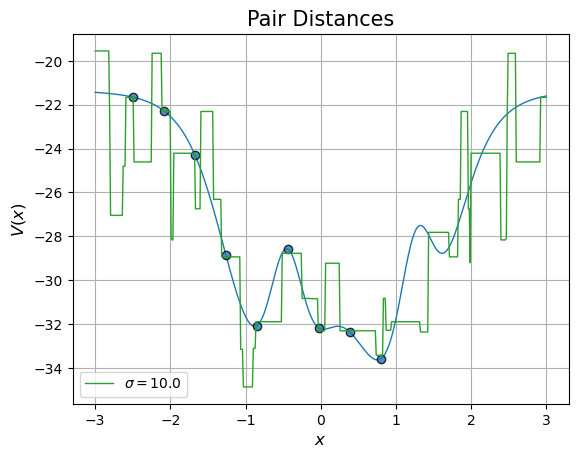

In [17]:
fig, ax = plt.subplots()
sigma = 10.0
xs = np.linspace(-3.0, 3.0, 500)

ax.set_title(r"Pair Distances", fontsize=15)

ax.plot(xs, pot_es, lw=1)
ax.plot(sample_points, pot_es_sampled, "o", c="C0", markeredgecolor="k", alpha=0.8)
ax.set_ylabel(r"$V(x)$", fontsize=12)
ax.set_xlabel(r"$x$", fontsize=12)
ax.grid()

regressor = Gaussian_kernel_regressor(x_data=pair_desc_sampled, y_data=pot_es_sampled, lamb=1e-4, sigma=sigma)
y_pred = regressor.sample(pair_descs)
ax.plot(xs, y_pred, lw=1, label=rf"$\sigma=${sigma}", c="C2")
ax.legend()

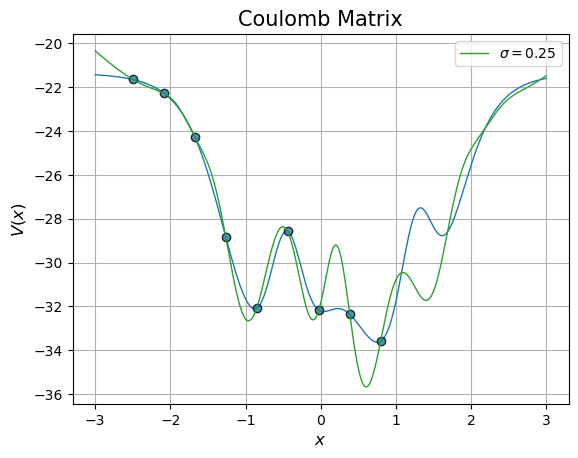

In [23]:
fig, ax = plt.subplots()
sigma = .25
xs = np.linspace(-3.0, 3.0, 500)

ax.set_title(r"Coulomb Matrix", fontsize=15)

ax.plot(xs, pot_es, lw=1)
ax.plot(sample_points, pot_es_sampled, "o", c="C0", markeredgecolor="k", alpha=0.8)
ax.set_ylabel(r"$V(x)$", fontsize=12)
ax.set_xlabel(r"$x$", fontsize=12)
ax.grid()

regressor = Gaussian_kernel_regressor(x_data=coul_desc_sampled, y_data=pot_es_sampled, lamb=1e-4, sigma=sigma)
y_pred = regressor.sample(coul_descs)
ax.plot(xs, y_pred, lw=1, label=rf"$\sigma=${sigma}", c="C2")
ax.legend()